In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter



use_cuda = torch.cuda.is_available()


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [2]:
data_dir = '../data/raw/airlinersnet/'
batch_size = 10
feature_extract=True

In [3]:
def load_data(data_dir):
    # Data loading and normalization for training
    norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    data_transforms = {
        'train':transforms.Compose([
        transforms.Resize(240),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(*norm)
        ]),
        'valid':transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(*norm)
        ]),
        'test':transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(*norm)
        ]),
    }

    # Load the datasets with ImageFolder
    image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

    # Dataloaders
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    return image_datasets, dataloaders, dataset_sizes


In [4]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



In [5]:
def init_model():
    model_transfer = models.densenet161(pretrained=True)


    num_classes = len(image_datasets['train'].class_to_idx)
    num_features = model_transfer.classifier.in_features
    input_size = model_transfer.classifier.state_dict()[next(iter(model_transfer.classifier.state_dict()))].size(1)
    hidden_units = int(input_size/2)


    model_transfer.classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(input_size, hidden_units)),
                                ('relu', nn.ReLU()),
                                ('drop', nn.Dropout(0.4)),
                                ('fc2', nn.Linear(hidden_units, num_classes))
    ]))
        

    if use_cuda:
        model_transfer = model_transfer.cuda()
    return model_transfer

In [6]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    # Tensorboard writer
    writer = SummaryWriter()
    """returns trained model"""
    writer.flush()
    
    print('Training for {} epochs on {}\n'.format(n_epochs, 'GPU' if use_cuda else 'CPU'))
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    losses = {'train':[], 'validation':[]}
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx+1))*(loss.data-train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += ((1/(batch_idx+1))*(loss.data-valid_loss))
                ## update the average validation loss

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Valid", valid_loss, epoch)


        ## TODO: save the model if validation loss has decreased
        if valid_loss<valid_loss_min:
            print('Saving model', save_path)
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # plotting losses
    plt.plot(losses['train'], label='Training Loss')
    plt.plot(losses['validation'], label='Validation Loss')
    plt.legend()
    _ = plt.ylim()
    
    # return trained model
    return model


In [7]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [8]:
def predict(img_path, model):

    img = Image.open(img_path)

    inputs = transform(img).unsqueeze(dim=0)

    model.eval()

    with torch.no_grad():
        if use_cuda:
            inputs = inputs.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    model.train()

    
    return preds.cpu().numpy()[0]

In [9]:
image_datasets, dataloaders, dataset_sizes = load_data(data_dir)

In [10]:
import json
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)

class_names = [cat_to_name[x] for x in image_datasets['train'].classes]

In [11]:
print([(cat_to_name[x], x) for x in image_datasets['train'].classes])

[('Boeing 707', '0'), ('Boeing 717', '1'), ('ATR 72', '10'), ('Airbus A220', '11'), ('Airbus A300', '12'), ('Airbus A310', '13'), ('Airbus A320 Family', '14'), ('Airbus A330', '15'), ('Airbus A340', '16'), ('Airbus A350', '17'), ('Airbus A380', '18'), ('Bombardier DHC-8-400', '19'), ('Boeing 727', '2'), ('Bombardier CRJ 200 Series', '20'), ('Bombardier CRJ 700 Series', '21'), ('Embraer ERJ Family', '22'), ('Embraer E-Jet Family', '23'), ('Boeing 737', '3'), ('Boeing 747', '4'), ('Boeing 757', '5'), ('Boeing 767', '6'), ('Boeing 777', '7'), ('Boeing 787', '8'), ('ATR 42', '9')]


In [12]:
map_dict = {}
for i in image_datasets['train'].classes:
    map_dict[i] = cat_to_name[i]

In [13]:
with open('new_mapping.json','w') as f:
    json.dump(map_dict, f)

In [14]:
map_dict

{'0': 'Boeing 707',
 '1': 'Boeing 717',
 '10': 'ATR 72',
 '11': 'Airbus A220',
 '12': 'Airbus A300',
 '13': 'Airbus A310',
 '14': 'Airbus A320 Family',
 '15': 'Airbus A330',
 '16': 'Airbus A340',
 '17': 'Airbus A350',
 '18': 'Airbus A380',
 '19': 'Bombardier DHC-8-400',
 '2': 'Boeing 727',
 '20': 'Bombardier CRJ 200 Series',
 '21': 'Bombardier CRJ 700 Series',
 '22': 'Embraer ERJ Family',
 '23': 'Embraer E-Jet Family',
 '3': 'Boeing 737',
 '4': 'Boeing 747',
 '5': 'Boeing 757',
 '6': 'Boeing 767',
 '7': 'Boeing 777',
 '8': 'Boeing 787',
 '9': 'ATR 42'}

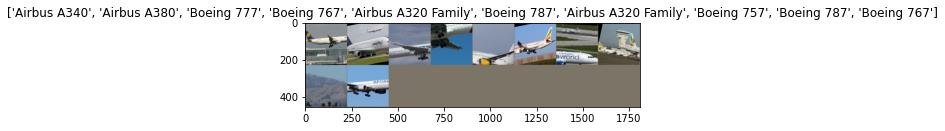

In [15]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
model_transfer = init_model()

In [17]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [18]:
# model_transfer = train(30, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_densenet_sgd_30_airlinersnet.pt')


In [19]:
# torch.save(model_transfer, 'densenet_full_-30-model.pth')

In [20]:
model_transfer.load_state_dict(torch.load('model_densenet_sgd_30_airlinersnet.pt'))

<All keys matched successfully>

In [21]:
# test(dataloaders, model_transfer, criterion_transfer, use_cuda)

In [22]:


transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
                                                        
def predict_aircraft(img_path):
    idx = predict(img_path, model_transfer)
    return class_names[idx]

In [23]:
def plot_image(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

def caption_images(img_path):
    print(f"This looks like a: {predict_aircraft(img_path)}")
    plot_image(img_path)
    

In [24]:
from glob import glob
import numpy as np
import random
import cv2

In [25]:
extra_test_img_dir = glob("../data/processed/test_images/*")

(22, 'Boeing 787')
(8, 'Airbus A340')
(10, 'Airbus A380')
(9, 'Airbus A350')
(22, 'Boeing 787')


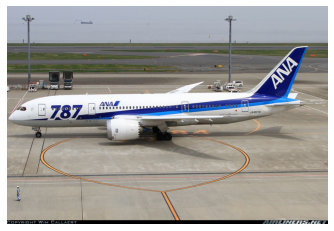

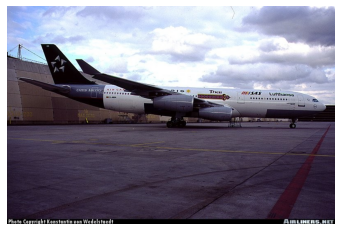

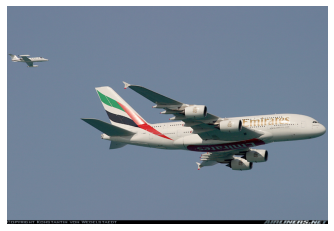

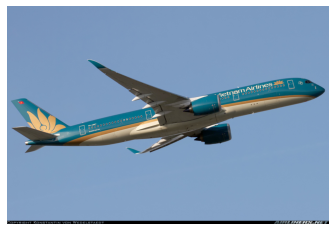

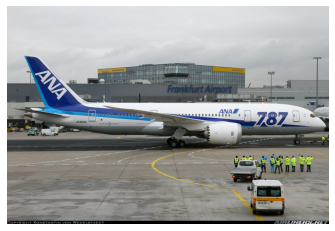

In [26]:
for i in random.sample(list(extra_test_img_dir),5):
    print((predict(i, model_transfer), class_names[predict(i, model_transfer)]))
    plot_image(i)


This looks like a: Boeing 737
This looks like a: Airbus A350
This looks like a: Airbus A220
This looks like a: Boeing 787
This looks like a: Airbus A350


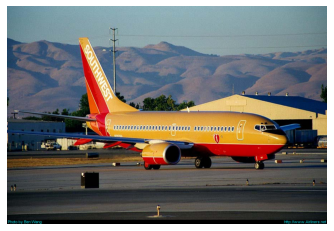

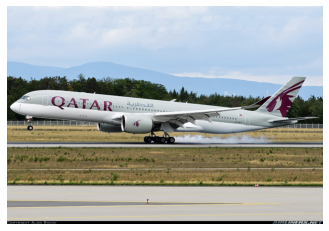

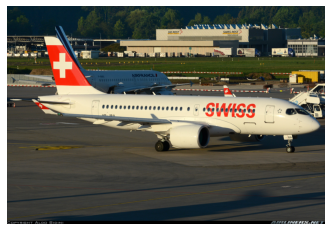

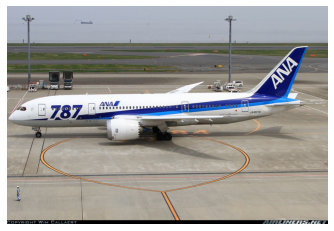

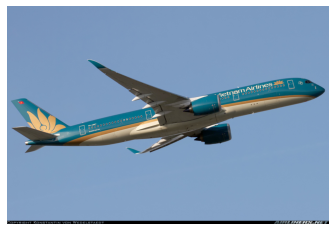

In [27]:
for i in random.sample(list(extra_test_img_dir),5):
    caption_images(i)